In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot
import scipy.signal
plt.rcParams['figure.figsize'] = 16, 16
import re
import torch
from torch import nn, autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import math
import skimage
from skimage import filters
from skimage import data as skd
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
data = pd.read_json("./Data/train.json")
test = pd.read_json("./Data/test.json")

def sampleImg(train,x):
    #returns a random sample set of 4 icebergs and ships
    icebergs = train[train.is_iceberg==1].sample(n=x)
    ships = train[train.is_iceberg==0].sample(n=x)
    
    return(ships,icebergs)
    
def common_size(a1, a2):
    #sets the size of two
    (r1, c1) = a1.shape
    (r2, c2) = a2.shape
    return (a1[r1-r2 if r1>r2 else 0:,
               c1-c2 if c1>c2 else 0:],
            a2[r2-r1 if r2>r1 else 0::,
               c2-c1 if c2>c1 else 0:])

def gradient(im):
    # Applies a gradient by using 2 simple 2d convolutions
    imv, imh = common_size(scipy.signal.convolve2d(im, [[1., -1.]],mode='valid',boundary='fill',fillvalue=0),
                           scipy.signal.convolve2d(im, [[1.], [-1.]],mode='valid',boundary='fill',fillvalue=0))
    return np.sqrt(np.power(imv, 2)+np.power(imh, 2))

#Edge detection kernel
def gradientEdgeDetect(im):
    imv, imh = common_size(scipy.signal.convolve2d(im, [[-1,0, -1],[-2,0,2],[-1,0,1]],mode='valid',boundary='fill',fillvalue=0),
                           scipy.signal.convolve2d(im, [[1,2,1], [0,0,0],[-1,-2,-1]],mode='valid',boundary='fill',fillvalue=0))
    return np.sqrt(np.power(imv, 2)+np.power(imh, 2))

#Edge detection kernel
def gradientEdgeDetect2(im):
    imv, imh = common_size(scipy.signal.convolve2d(im, [[-1,0, 1],[-1,0,1],[-1,0,1]],mode='valid',boundary='fill',fillvalue=0),
                           scipy.signal.convolve2d(im, [[1,1,1], [0,0,0],[-1,-1,-1]],mode='valid',boundary='fill',fillvalue=0))
    return np.sqrt(np.power(imv, 2)+np.power(imh, 2))

#Edge detection kernel
def gradientSobel(im):
    imv, imh = common_size(scipy.signal.convolve2d(im, [[1,0, -1],[2,0,-2],[1,0,-1]],mode='valid',boundary='fill',fillvalue=0),
                           scipy.signal.convolve2d(im, [[1,2,1], [0,0,0],[-1,-2,-1]],mode='valid',boundary='fill',fillvalue=0))
    return np.sqrt(np.power(imv, 2)+np.power(imh, 2))

def gradientLaplace(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,-1, 0],[-1,4,-1],[0,-1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace2(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,-1, 0],[-1,8,-1],[0,-1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace3(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,-1, 0],[-1,5,-1],[0,-1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace4(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,-4,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace5(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,-5,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace6(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,8,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace7(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,9,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace8(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,-8,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def gradientLaplace9(im):
    #Smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,1, 0],[1,-9,1],[0,1,0]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def bigLaplace1(im):
    #Large smoothing gradient
    imh = scipy.signal.convolve2d(im, [[0,0,0,0,0],[0,0,-1,0,0],[0,-1,8,-1,0],[0,0,-1,0,0],[0,0,0,0,0]],
                                  mode='valid',boundary='fill',fillvalue=0)
    return imh

def Emboss(im):
    # Convolution that adds an emboss effect to a 2d array
    imh = scipy.signal.convolve2d(im, [[-2,-1, 0],[-1,1,1],[0,1,2]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def SobelBottom(im):
    # Sobel convoltion that detects bottom edges
    imh = scipy.signal.convolve2d(im, [[-1,-2, -1],[0,0,0],[1,2,1]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def SobelTop(im):
    # Sobel convoltion that detects top edges
    imh = scipy.signal.convolve2d(im, [[1,2, 1],[0,0,0],[-1,-2,-1]],mode='valid',boundary='fill',fillvalue=0)
    return imh
    
def SobelLeft(im):
    # Sobel convoltion that detects left edges
    imh = scipy.signal.convolve2d(im, [[1,0, -1],[2,0,-2],[1,0,-1]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def SobelRight(im):
    # Sobel convolution that detects right edges
    imh = scipy.signal.convolve2d(im, [[-1,0, 1],[-2,0,2],[-1,0,1]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def outline(im):
    #Edge detection convolution
    imh = scipy.signal.convolve2d(im, [[-1,-1, -1],[-1,8,-1],[-1,-1,-1]],mode='valid',boundary='fill',fillvalue=0)
    return imh

def multiProcess(list,i):
    # Takes a list of convolutions and applies them to an array
    transforms = list
    
    arr = np.reshape(np.array(data.iloc[i,0]),(75,75))
    
    for j in transforms:
        arr=skimage.transform.resize(j(arr),(75,75))
             
    return arr

def callSet(list,dataset):
    # Iterates through the data set and perfoms a list of changes for preprocessing
    i=0
    for index, row in dataset.iterrows():
        dataset['band_1'][i] = multiProcess(list,i)
        dataset['band_2'][i] = multiProcess(list,i)
        i=i+1
    return dataset

def multiProcess2(list,i):
    # Takes a list of convolutions and applies them to an array
    transforms = list
    
    arr = np.reshape(np.array(test.iloc[i,0]),(75,75))
    
    for j in transforms:
        arr=skimage.transform.resize(j(arr),(75,75))
             
    return arr

def callSet2(list,dataset):
    # Iterates through the data set and perfoms a list of changes for preprocessing
    i=0
    for index, row in dataset.iterrows():
        dataset['band_1'][i] = multiProcess2(list,i)
        dataset['band_2'][i] = multiProcess2(list,i)
        i=i+1
    return dataset

def addFlip(dataset):
    # Flips 75% of the pictures and adds to the data passed
    original = dataset
    sub = dataset.sample(frac=0.75)
    dataset = dataset[~dataset.isin(sub)].dropna()
    for index, row in dataset.iterrows():
        dataset['band_1'] = np.flipud(dataset['band_1'])
        dataset['band_2'] = np.flipud(dataset['band_2'])
    
    original = original.append(pd.DataFrame(data = dataset), ignore_index=True)
    
    return original

def addFlip2(dataset):
    # Flips left to right, 50% of the pictures and adds to the data passed
    original = dataset
    sub = dataset.sample(frac=0.5)
    dataset = dataset[~dataset.isin(sub)].dropna()
    for index, row in dataset.iterrows():
        dataset['band_1'][index] = np.fliplr(dataset['band_1'][index])
        dataset['band_2'][index] = np.fliplr(dataset['band_2'][index])

    
    original = original.append(pd.DataFrame(data = dataset), ignore_index=True)
    
    return original


def fillHoles(dataset):
    # Applies a filter for filling holes
    for index, row in dataset.iterrows():
        
        img = np.reshape((dataset['band_1'][index]),(75,75))
        img = rescale_intensity(img)
        seed = np.copy(img)
        seed[1:-1, 1:-1] = img.max()
        mask = img
        filled = reconstruction(seed, mask, method='erosion')
        filled = skimage.transform.resize(filled,(75,75))
        dataset['band_1'][index] = filled

        img = np.reshape(np.array(dataset['band_2'][index]),(75,75))
        img = rescale_intensity(img)
        seed = np.copy(img)
        seed[1:-1, 1:-1] = img.max()
        mask = img
        filled = reconstruction(seed, mask, method='erosion')
        filled = skimage.transform.resize(filled,(75,75))
        dataset['band_2'][index] = filled
        
        print(index,' of ',len(dataset))
    
    return dataset
   

In [9]:
import skimage
from skimage import filters
from skimage import data as skd
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
import warnings
warnings.filterwarnings('ignore')

# This segment takes lists of gradients to pass over our data and creates new data sests
#  It has a step for the training data and the validation set
#  On the training data, we also add 50% of the records to our set, but flip the images

list1=[gradientLaplace2,gradientLaplace6,gradientLaplace7,
      gradientLaplace7,gradientEdgeDetect2,gradientLaplace7
        ,gradientLaplace9,gradientLaplace2
      ]
list2=[gradientLaplace2,gradientLaplace6,gradientLaplace7,
      gradientLaplace7,gradientEdgeDetect2,gradientLaplace7
        ,gradientLaplace9,gradientLaplace2,gradientEdgeDetect2,gradientLaplace9
      ]
list3=[gradientLaplace2,gradientLaplace6,gradientLaplace7,
      gradientLaplace7,gradientEdgeDetect2,gradientLaplace7
        ,gradientLaplace9,gradientLaplace2,gradientEdgeDetect2,gradientLaplace9,Emboss
      ]
list4=[gradientLaplace2,gradientLaplace6,gradientLaplace7,
      gradientLaplace7,gradientEdgeDetect2,gradientLaplace7
        ,gradientLaplace9,gradientLaplace2,Emboss]




In [ ]:

data1 = callSet(list1,data)
data1 = addFlip(data1)
data1.to_pickle('AugmententData1.pk1')
data2 = callSet(list2,data)
data2 = addFlip(data2)
data2.to_pickle('AugmententData2.pk1')
data3 = callSet(list3,data)
data3 = addFlip(data3)
data3.to_pickle('AugmententData3.pk1')
data4 = callSet(list4,data)
data4 = addFlip(data4)
data4.to_pickle('AugmententData4.pk1')
data5 = fillHoles(data)
data5 = addFlip(data5)
data5.to_pickle('AugmententData5.pk1')

In [3]:
data1 = pd.read_pickle('AugmententData1.pk1')
data2 = pd.read_pickle('AugmententData2.pk1')
data3 = pd.read_pickle('AugmententData3.pk1')
data4 = pd.read_pickle('AugmententData4.pk1')
data5 = pd.read_pickle('AugmententData5.pk1')

In [15]:
test1 = callSet2(list1,test)
test1.to_pickle('AugmententTest1.pk1')
test2 = callSet2(list2,test)
test2.to_pickle('AugmententTest2.pk1')
test3 = callSet2(list3,test)
test3.to_pickle('AugmententTest3.pk1')
test4 = callSet2(list4,test)
test4.to_pickle('AugmententTest4.pk1')
test5 = fillHoles(test)
test5.to_pickle('AugmententTest5.pk1')

NameError: name 'rescale_intensity' is not defined

In [16]:
test1 = pd.read_pickle('AugmententTest1.pk1')
test2 = pd.read_pickle('AugmententTest2.pk1')
test3 = pd.read_pickle('AugmententTest3.pk1')
test4 = pd.read_pickle('AugmententTest4.pk1')
test5 = pd.read_pickle('AugmententTest5.pk1')

In [35]:

data1.head()
data4['band_1']=data4['band_1']/1000000000000000000000
data4['band_2']=data4['band_2']/1000000000000000000000

In [38]:
data4.head()
#d = decimal.Decimal(data1['band_1'][1])
#>>> d.as_tuple().exponent
test4['band_1']=test4['band_1']/10000000000000000
test4['band_2']=test4['band_2']/10000000000000000

In [5]:
# Augement Data
#data = pd.read_pickle('AugmententData5.pk1')
#test = pd.read_pickle('AugmententTest5.pk1')
### Prepare the data for nn
#data = addFlip(data)

data['band_1'] = data['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x: np.array(x).reshape(75, 75))
# Augment part 2
#data = addFlip2(data)
data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors = 'coerce')

train = data.sample(frac = 0.75)
val = data[~data.isin(train)].dropna()
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
full_tr = np.stack([band_1_tr, band_2_tr], axis = 1)

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
full_val = np.stack([band_1_val, band_2_val], axis = 1)

test['band_1'] = test['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x: np.array(x).reshape(75, 75))
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors = 'coerce')
band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
full_test = np.stack([band_1_test,band_2_test],axis = 1)

test_bands = torch.from_numpy(full_test).float()


train_bands = torch.from_numpy(full_tr).float()
train_labels = torch.from_numpy(train['is_iceberg'].values).long()
train_set = TensorDataset(train_bands, train_labels)

val_bands = torch.from_numpy(full_val).float()
val_labels = torch.from_numpy(val['is_iceberg'].values).long()
val_set = TensorDataset(val_bands, val_labels)

def resample():
    train = data.sample(frac=0.75)
    val = data[~data.isin(train)].dropna()
    band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
    band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
    full_tr = np.stack([band_1_tr, band_2_tr], axis=1)
    band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
    band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
    full_val = np.stack([band_1_val, band_2_val], axis=1)
    band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
    band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
    train_bands = torch.from_numpy(full_tr).float()
    train_labels = torch.from_numpy(train['is_iceberg'].values).long()
    train_set = TensorDataset(train_bands, train_labels)
    val_bands = torch.from_numpy(full_val).float()
    val_labels = torch.from_numpy(val['is_iceberg'].values).long()
    val_set = TensorDataset(val_bands, val_labels)
    return train_set,val_set

train_set,val_set = resample()



In [34]:
# Build nn

#Relu Decision - 
#https://arxiv.org/pdf/1505.00853.pdf

# Why Max Pool - 
#https://www.quora.com/What-is-the-benefit-of-using-average-pooling-rather-than-max-pooling

#Why Sigmoid -
#https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.RRpool1 = torch.nn.Sequential(
            torch.nn.Conv2d(2, 32, kernel_size=(3,3),padding=2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(.1),
            torch.nn.MaxPool2d((3,3),stride=(2,2))
        )
        
        self.RRpool2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=(3,3),padding=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(.2),
            torch.nn.MaxPool2d((2,2),stride=(2,2))
        )
        
        self.RRpool3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3,padding=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(.3),
            torch.nn.MaxPool2d((2,2),stride=(2,2))
        )
        
        self.res = torch.nn.Sequential(
            nn.Dropout(.1),
            torch.nn.Conv2d(128, 128, kernel_size=2,padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2),stride=(2,2))
        )
        
        self.classifier = torch.nn.Linear(6272, 1)             
    
        self.sig = nn.Sigmoid()
                   
    def forward(self, x):
        x = self.RRpool1(x)
        x = self.RRpool2(x)
        x = self.RRpool3(x)
        x = self.res(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)                
        x = self.sig(x)
        return x  

model = Net()
model = model.cuda()
print(model)

Net (
  (RRpool1): Sequential (
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU (0.01)
    (2): Dropout (p = 0.1)
    (3): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (RRpool2): Sequential (
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): Dropout (p = 0.2)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (RRpool3): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): Dropout (p = 0.3)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (res): Sequential (
    (0): Dropout (p = 0.1)
    (1): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear (6272 -> 1)
  (sig): Sigmoid ()
)


In [35]:
loss_func = torch.nn.BCELoss()
criterion = loss_func
all_losses = []
val_losses = []
# What is adam optimizer?
#https://arxiv.org/pdf/1412.6980.pdf
optimizer = torch.optim.Adam(model.parameters(),lr=.0005,weight_decay=5e-5)

def fit (train, val, num_epochs, batch_size):
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
        numerator = 0
        for data,target in train_loader:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True))
            numerator = numerator+1
            output = model(data.cuda())
            loss = criterion(output, target.float())
            running_loss += loss.data[0] * target.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            all_losses.append(running_loss / (batch_size * numerator))
            
            #print('[{}/{}] Loss: {:.6f}'.format(
                #epoch + 1, num_epochs, running_loss / (batch_size * numerator)))


        print('Finish {} epoch, Loss: {:.6f}'.format(epoch + 1, running_loss / (len(train))))

        model.eval()
        eval_loss = 0
        eval_acc = 0
        for data,target in val_loader:
            data, target = Variable(data.cuda(async=True)),Variable(target.cuda(async=True))
            out = model(data)
            loss = criterion(out, target.float())
            eval_loss += loss.data[0] * target.size(0)

        print('Val Loss: {:.6f}'.format(eval_loss / (len(val))))
        val_losses.append(eval_loss / (len(val)))
        print()

In [5]:
#Regular Data
fit(train_set, val_set, 50, 128)

Finish 1 epoch, Loss: 0.990073
Val Loss: 0.725507

Finish 2 epoch, Loss: 0.689978
Val Loss: 0.692454

Finish 3 epoch, Loss: 0.651536
Val Loss: 0.663210

Finish 4 epoch, Loss: 0.612005
Val Loss: 0.627131

Finish 5 epoch, Loss: 0.583200
Val Loss: 0.598808

Finish 6 epoch, Loss: 0.569493
Val Loss: 0.565249

Finish 7 epoch, Loss: 0.558487
Val Loss: 0.557115

Finish 8 epoch, Loss: 0.558639
Val Loss: 0.598755

Finish 9 epoch, Loss: 0.554458
Val Loss: 0.569708

Finish 10 epoch, Loss: 0.540502
Val Loss: 0.541424

Finish 11 epoch, Loss: 0.521599
Val Loss: 0.531837

Finish 12 epoch, Loss: 0.516494
Val Loss: 0.501370

Finish 13 epoch, Loss: 0.492450
Val Loss: 0.485612

Finish 14 epoch, Loss: 0.460340
Val Loss: 0.493720

Finish 15 epoch, Loss: 0.420617
Val Loss: 0.452566

Finish 16 epoch, Loss: 0.364009
Val Loss: 0.379335

Finish 17 epoch, Loss: 0.395842
Val Loss: 0.408773

Finish 18 epoch, Loss: 0.392372
Val Loss: 0.476850

Finish 19 epoch, Loss: 0.366014
Val Loss: 0.425537

Finish 20 epoch, Loss

In [5]:
#List 1 Tranformations
fit(train_set, val_set, 50, 128)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])) is deprecated. Please ensure they have the same size.

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])) is deprecated. Please ensure they have the same size.



Finish 1 epoch, Loss: 14.795769
Val Loss: 14.066702

Finish 2 epoch, Loss: 14.489438
Val Loss: 14.569084

Finish 3 epoch, Loss: 14.412855
Val Loss: 14.569084

Finish 4 epoch, Loss: 13.708295
Val Loss: 13.514081

Finish 5 epoch, Loss: 13.080317
Val Loss: 13.212652

Finish 6 epoch, Loss: 14.657920
Val Loss: 14.418369

Finish 7 epoch, Loss: 13.876777
Val Loss: 11.554791

Finish 8 epoch, Loss: 13.156900
Val Loss: 14.619322

Finish 9 epoch, Loss: 14.213740
Val Loss: 14.569084

Finish 10 epoch, Loss: 14.520071
Val Loss: 13.112175

Finish 11 epoch, Loss: 13.539813
Val Loss: 13.162414

Finish 12 epoch, Loss: 13.999309
Val Loss: 15.021227

Finish 13 epoch, Loss: 13.892093
Val Loss: 13.011699

Finish 14 epoch, Loss: 13.754244
Val Loss: 14.619322

Finish 15 epoch, Loss: 14.428172
Val Loss: 12.939462

Finish 16 epoch, Loss: 13.539813
Val Loss: 13.011699

Finish 17 epoch, Loss: 14.370043
Val Loss: 14.619322

Finish 18 epoch, Loss: 14.489438
Val Loss: 14.619322

Finish 19 epoch, Loss: 14.489438
Val 

In [8]:
#List 2 Transformations
fit(train_set, val_set, 50, 128)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])) is deprecated. Please ensure they have the same size.

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning:

Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])) is deprecated. Please ensure they have the same size.



Finish 1 epoch, Loss: 14.611970
Val Loss: 13.889921

Finish 2 epoch, Loss: 14.642603
Val Loss: 13.741100

Finish 3 epoch, Loss: 13.019051
Val Loss: 13.741100

Finish 4 epoch, Loss: 13.386648
Val Loss: 13.889921

Finish 5 epoch, Loss: 14.611970
Val Loss: 13.889921

Finish 6 epoch, Loss: 14.275006
Val Loss: 13.741100

Finish 7 epoch, Loss: 13.019051
Val Loss: 13.741100

Finish 8 epoch, Loss: 14.244374
Val Loss: 13.889921

Finish 9 epoch, Loss: 14.642603
Val Loss: 13.741100

Finish 10 epoch, Loss: 13.019051
Val Loss: 13.741100

Finish 11 epoch, Loss: 14.734502
Val Loss: 13.889921

Finish 12 epoch, Loss: 13.754245
Val Loss: 13.741100

Finish 13 epoch, Loss: 13.019051
Val Loss: 13.741100

Finish 14 epoch, Loss: 14.428172
Val Loss: 13.889921

Finish 15 epoch, Loss: 13.539813
Val Loss: 13.741100

Finish 16 epoch, Loss: 13.110950
Val Loss: 13.889921

Finish 17 epoch, Loss: 13.590923
Val Loss: 13.741100

Finish 18 epoch, Loss: 13.019051
Val Loss: 13.741100

Finish 19 epoch, Loss: 13.019051
Val 

In [25]:
# Peaks with ud flip
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 0.693028
Val Loss: 0.693832

Finish 2 epoch, Loss: 0.689652
Val Loss: 0.688490

Finish 3 epoch, Loss: 0.682330
Val Loss: 0.686627

Finish 4 epoch, Loss: 0.680093
Val Loss: 0.682953

Finish 5 epoch, Loss: 0.676474
Val Loss: 0.675084

Finish 6 epoch, Loss: 0.671709
Val Loss: 0.674299

Finish 7 epoch, Loss: 0.669646
Val Loss: 0.668070

Finish 8 epoch, Loss: 0.657082
Val Loss: 0.666878

Finish 9 epoch, Loss: 0.648468
Val Loss: 0.658624

Finish 10 epoch, Loss: 0.650734
Val Loss: 0.659892

Finish 11 epoch, Loss: 0.628326
Val Loss: 0.652738

Finish 12 epoch, Loss: 0.623623
Val Loss: 0.652285

Finish 13 epoch, Loss: 0.621109
Val Loss: 0.656006

Finish 14 epoch, Loss: 0.610370
Val Loss: 0.643513

Finish 15 epoch, Loss: 0.596704
Val Loss: 0.637437

Finish 16 epoch, Loss: 0.587011
Val Loss: 0.641519

Finish 17 epoch, Loss: 0.573281
Val Loss: 0.631835

Finish 18 epoch, Loss: 0.565566
Val Loss: 0.618477

Finish 19 epoch, Loss: 0.542477
Val Loss: 0.613539

Finish 20 epoch, Loss

In [21]:
# Peaks
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 0.693802
Val Loss: 0.692888

Finish 2 epoch, Loss: 0.691958
Val Loss: 0.692439

Finish 3 epoch, Loss: 0.689229
Val Loss: 0.689544

Finish 4 epoch, Loss: 0.682131
Val Loss: 0.685644

Finish 5 epoch, Loss: 0.677458
Val Loss: 0.692493

Finish 6 epoch, Loss: 0.686095
Val Loss: 0.684510

Finish 7 epoch, Loss: 0.674490
Val Loss: 0.680267

Finish 8 epoch, Loss: 0.668454
Val Loss: 0.679330

Finish 9 epoch, Loss: 0.664601
Val Loss: 0.678636

Finish 10 epoch, Loss: 0.658016
Val Loss: 0.675187

Finish 11 epoch, Loss: 0.657670
Val Loss: 0.675753

Finish 12 epoch, Loss: 0.649468
Val Loss: 0.674858

Finish 13 epoch, Loss: 0.646808
Val Loss: 0.673437

Finish 14 epoch, Loss: 0.643089
Val Loss: 0.670535

Finish 15 epoch, Loss: 0.634541
Val Loss: 0.667918

Finish 16 epoch, Loss: 0.632330
Val Loss: 0.665988

Finish 17 epoch, Loss: 0.630016
Val Loss: 0.672955

Finish 18 epoch, Loss: 0.616629
Val Loss: 0.670123

Finish 19 epoch, Loss: 0.615936
Val Loss: 0.660563

Finish 20 epoch, Loss

In [29]:
# Peaks with LR flip
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 0.692507
Val Loss: 0.693132

Finish 2 epoch, Loss: 0.688101
Val Loss: 0.688126

Finish 3 epoch, Loss: 0.684923
Val Loss: 0.685753

Finish 4 epoch, Loss: 0.682607
Val Loss: 0.687376

Finish 5 epoch, Loss: 0.678115
Val Loss: 0.681350

Finish 6 epoch, Loss: 0.674677
Val Loss: 0.676234

Finish 7 epoch, Loss: 0.667569
Val Loss: 0.674556

Finish 8 epoch, Loss: 0.670224
Val Loss: 0.680947

Finish 9 epoch, Loss: 0.661704
Val Loss: 0.667071

Finish 10 epoch, Loss: 0.658628
Val Loss: 0.669821

Finish 11 epoch, Loss: 0.665094
Val Loss: 0.669913

Finish 12 epoch, Loss: 0.652107
Val Loss: 0.664141

Finish 13 epoch, Loss: 0.661005
Val Loss: 0.673642

Finish 14 epoch, Loss: 0.647999
Val Loss: 0.660455

Finish 15 epoch, Loss: 0.641039
Val Loss: 0.662199

Finish 16 epoch, Loss: 0.641283
Val Loss: 0.659192

Finish 17 epoch, Loss: 0.633623
Val Loss: 0.653039

Finish 18 epoch, Loss: 0.622898
Val Loss: 0.645453

Finish 19 epoch, Loss: 0.611244
Val Loss: 0.640289

Finish 20 epoch, Loss

In [16]:
# Normal data with added flipped data ud
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 1.011563
Val Loss: 0.691732

Finish 2 epoch, Loss: 0.698770
Val Loss: 0.688883

Finish 3 epoch, Loss: 0.683606
Val Loss: 0.673905

Finish 4 epoch, Loss: 0.650461
Val Loss: 0.627719

Finish 5 epoch, Loss: 0.642834
Val Loss: 0.629245

Finish 6 epoch, Loss: 0.637583
Val Loss: 0.630728

Finish 7 epoch, Loss: 0.635412
Val Loss: 0.627267

Finish 8 epoch, Loss: 0.637619
Val Loss: 0.623098

Finish 9 epoch, Loss: 0.632792
Val Loss: 0.625583

Finish 10 epoch, Loss: 0.632167
Val Loss: 0.616582

Finish 11 epoch, Loss: 0.626365
Val Loss: 0.618299

Finish 12 epoch, Loss: 0.614940
Val Loss: 0.608956

Finish 13 epoch, Loss: 0.604439
Val Loss: 0.596849

Finish 14 epoch, Loss: 0.609006
Val Loss: 0.604028

Finish 15 epoch, Loss: 0.586850
Val Loss: 0.575531

Finish 16 epoch, Loss: 0.580236
Val Loss: 0.585996

Finish 17 epoch, Loss: 0.570677
Val Loss: 0.571469

Finish 18 epoch, Loss: 0.580396
Val Loss: 0.603144

Finish 19 epoch, Loss: 0.557748
Val Loss: 0.568166

Finish 20 epoch, Loss

In [36]:
# Normal data with added flipped data lr
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 0.881835
Val Loss: 0.688059

Finish 2 epoch, Loss: 0.669474
Val Loss: 0.644930

Finish 3 epoch, Loss: 0.593179
Val Loss: 0.559549

Finish 4 epoch, Loss: 0.568097
Val Loss: 0.555984

Finish 5 epoch, Loss: 0.560096
Val Loss: 0.551987

Finish 6 epoch, Loss: 0.553071
Val Loss: 0.538086

Finish 7 epoch, Loss: 0.539346
Val Loss: 0.518454

Finish 8 epoch, Loss: 0.516646
Val Loss: 0.493267

Finish 9 epoch, Loss: 0.480232
Val Loss: 0.516491

Finish 10 epoch, Loss: 0.487815
Val Loss: 0.467226

Finish 11 epoch, Loss: 0.432215
Val Loss: 0.414683

Finish 12 epoch, Loss: 0.429379
Val Loss: 0.425443

Finish 13 epoch, Loss: 0.389603
Val Loss: 0.407114

Finish 14 epoch, Loss: 0.396976
Val Loss: 0.411723

Finish 15 epoch, Loss: 0.371414
Val Loss: 0.355857

Finish 16 epoch, Loss: 0.351325
Val Loss: 0.357711

Finish 17 epoch, Loss: 0.354594
Val Loss: 0.348337

Finish 18 epoch, Loss: 0.367165
Val Loss: 0.348413

Finish 19 epoch, Loss: 0.345088
Val Loss: 0.351130

Finish 20 epoch, Loss

In [5]:
# Normal data with added flipped data ud and lr
fit(train_set, val_set, 100, 128)

Finish 1 epoch, Loss: 0.945056
Val Loss: 0.689194

Finish 2 epoch, Loss: 0.675255
Val Loss: 0.653131

Finish 3 epoch, Loss: 0.649016
Val Loss: 0.642653

Finish 4 epoch, Loss: 0.639737
Val Loss: 0.633777

Finish 5 epoch, Loss: 0.631727
Val Loss: 0.632499

Finish 6 epoch, Loss: 0.623757
Val Loss: 0.622207

Finish 7 epoch, Loss: 0.611989
Val Loss: 0.611450

Finish 8 epoch, Loss: 0.601811
Val Loss: 0.617763

Finish 9 epoch, Loss: 0.597810
Val Loss: 0.638178

Finish 10 epoch, Loss: 0.593348
Val Loss: 0.593488

Finish 11 epoch, Loss: 0.558463
Val Loss: 0.595605

Finish 12 epoch, Loss: 0.550747
Val Loss: 0.569951

Finish 13 epoch, Loss: 0.536932
Val Loss: 0.573467

Finish 14 epoch, Loss: 0.529209
Val Loss: 0.559304

Finish 15 epoch, Loss: 0.515048
Val Loss: 0.539052

Finish 16 epoch, Loss: 0.505047
Val Loss: 0.544518

Finish 17 epoch, Loss: 0.497403
Val Loss: 0.548573

Finish 18 epoch, Loss: 0.490586
Val Loss: 0.535926

Finish 19 epoch, Loss: 0.488572
Val Loss: 0.548071

Finish 20 epoch, Loss

In [ ]:
tests = Variable(test_bands.cuda())


tests = np.array(full_test, dtype=np.float32)
tests = Variable(torch.from_numpy(tests).cuda())
test['data']= tests

for index, row in test.iterrows():
    prediction = (model(test['data'][index]).float()) # probabilities     
    #p_test =   prediction.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    predicted = predicted.append({'id':row[index], 'is_iceberg':prediction},ignore_index=False)
#     df_pred = df_pred.append({'id':row['id'].astype(int), 'probability':p_test},ignore_index=True)


In [53]:
 x_data_np = np.array(full_test, dtype=np.float32)

In [54]:
x_data_np[1]

array([[[-26.0589695 , -26.0589695 , -26.0589695 , ..., -21.37950706,
         -21.37950706, -26.06124687],
        [-22.74645233, -22.74645233, -22.74645233, ..., -28.98365211,
         -23.87828064, -22.53942299],
        [-24.89912987, -24.89912987, -24.89912987, ..., -28.98365211,
         -22.53938484, -26.06128693],
        ..., 
        [-23.8764267 , -28.55809212, -28.55809212, ..., -27.39995003,
         -27.76969719, -23.64029694],
        [-28.55809212, -23.40684509, -23.40684509, ..., -27.39995003,
         -27.76969719, -23.64029694],
        [-23.40684509, -23.40684509, -23.87646675, ..., -27.39995003,
         -27.76969719, -23.64029694]],

       [[-25.75420761, -25.75420761, -25.75420761, ..., -25.46194267,
         -25.46194267, -27.76988983],
        [-21.74701309, -21.74701309, -21.74701309, ..., -26.37701797,
         -25.46194267, -23.64041138],
        [-27.04336929, -27.04336929, -27.04336929, ..., -26.37701797,
         -25.46198273, -23.18319321],
        ...,

In [3]:
data['band_1'] = data['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
data['band_1'][1]

array([[-12.242375, -14.920305, -14.920363, ..., -10.633402, -11.956054,
        -14.379026],
       [-13.046626, -14.077841, -12.728542, ..., -11.243189, -11.786291,
        -14.379026],
       [-15.248114, -14.0779  , -12.604514, ..., -15.680162, -13.51685 ,
        -14.454887],
       ..., 
       [-15.589596, -16.899685, -17.527912, ..., -11.78711 , -10.883234,
        -12.306804],
       [-14.761801, -15.503286, -15.333027, ...,  -9.793052,  -8.062263,
         -9.882715],
       [-13.178177, -15.503286, -14.375814, ..., -11.087559,  -8.246684,
         -8.666801]])

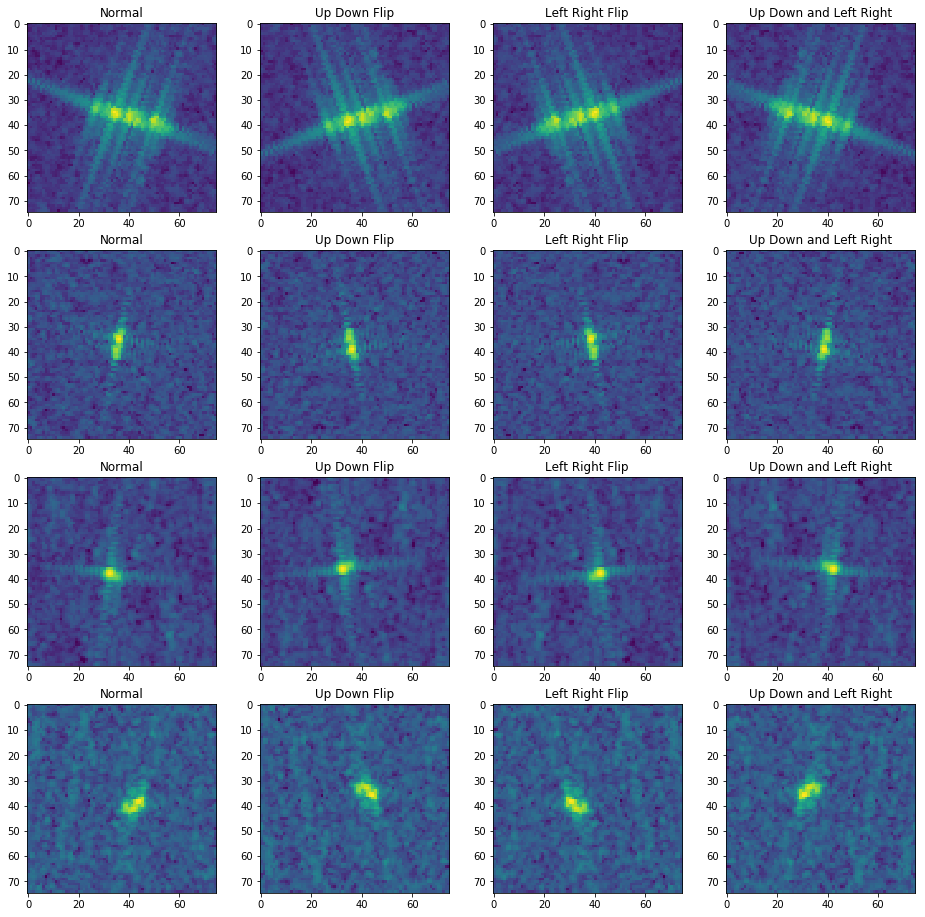

In [17]:
fig = plt.figure(1,figsize=(16,16))
ships,icebergs = sampleImg(train,4)
a=0
for i in range(4):
    a = a+1
    arr = (np.reshape(np.array(ships.iloc[i,0]),(75,75)))
    ax = fig.add_subplot(4,4,a)
    ax.imshow(arr,cmap='viridis')
    ax.set_title('Normal')
    arr = np.flipud(np.reshape(np.array(ships.iloc[i,0]),(75,75)))
    a=a+1
    ax = fig.add_subplot(4,4,a)
    ax.imshow(arr,cmap='viridis')
    ax.set_title('Up Down Flip')
    a = a+1
    arr = np.fliplr(np.reshape(np.array(ships.iloc[i,0]),(75,75)))
    ax = fig.add_subplot(4,4,a)
    ax.imshow(arr,cmap='viridis')
    ax.set_title('Left Right Flip')
    arr = np.fliplr(np.flipud(np.reshape(np.array(ships.iloc[i,0]),(75,75))))
    a=a+1
    ax = fig.add_subplot(4,4,a)
    ax.imshow(arr,cmap='viridis')
    ax.set_title('Up Down and Left Right')
    

plt.show()